In [2]:
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
import json,os
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

os.chdir("D:\CSP 571\yelp data")
business = pd.read_json('business.json', lines=True)

### First we will chek the columns of the business data

In [3]:
business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [4]:
business.categories

0                                         Golf, Active Life
1         Specialty Food, Restaurants, Dim Sum, Imported...
2                         Sushi Bars, Restaurants, Japanese
3                             Insurance, Financial Services
4         Plumbing, Shopping, Local Services, Home Servi...
                                ...                        
192604    Water Purification Services, Water Heater Inst...
192605                 Books, Mags, Music & Video, Shopping
192606    Home Services, Contractors, Landscaping, Mason...
192607                               Beauty & Spas, Barbers
192608                               Massage, Beauty & Spas
Name: categories, Length: 192609, dtype: object

### Business data consists of information based on a lot of categories such as Golf, Insurance, etc. but a single business can be categorized in multiple ways. Therefore, we shall split the categories in the "Category" column

In [5]:
business = business.assign(categories = business.categories.str.split(', ')).explode('categories')
cat = business.categories.value_counts()

In [6]:
cat = cat.to_frame().reset_index()

In [7]:
cat.columns = ['Categories', 'Count']
cat

,Categories,Count
0,Restaurants,59371
1,Shopping,31878
2,Food,29989
3,Home Services,19729
4,Beauty & Spas,19370
...,...,...
1295,Rotisserie Chicken,1
1296,Bulgarian,1
1297,Homeopathic,1
1298,Bocce Ball,1


### There are 1300 categories. We shall check top 10 categories.

In [8]:
cat= cat.sort_values(by = 'Count', ascending = False)

In [9]:
cat = cat[0:10]

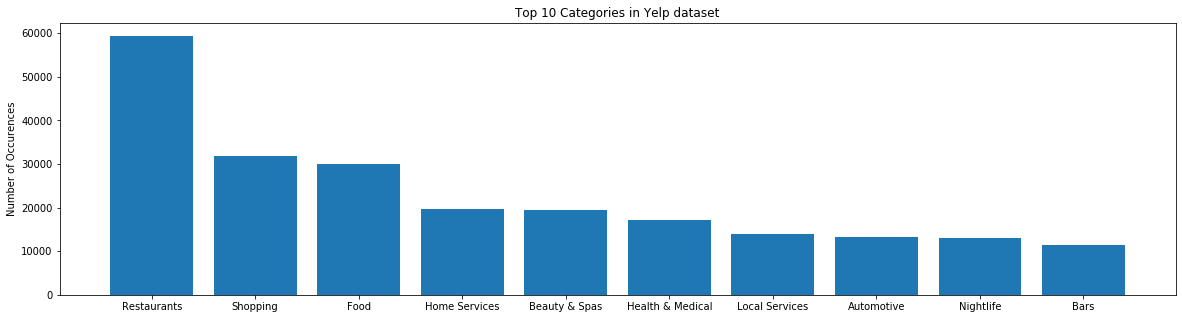

In [10]:
objects = list(cat.Categories)
y_pos = np.arange(len(objects))
Numbers = list(cat.Count)

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
plt.bar(y_pos, Numbers, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Occurences')
plt.title('Top 10 Categories in Yelp dataset')
plt.show()

### These are the top 10 categories in this data. But for our analysis, we shall focus more on business which comes in restaurant category. 

In [11]:
# business = business.assign(categories = business.categories.str.split(', ')).explode('categories')
# count = business.categories.value_counts().tolist()
# res_cat = business.categories.tolist()
# res_cat = list(set(res_cat))

In [12]:
# count = business.categories.value_counts().tolist()
# categories_list = business.categories.str.split().tolist()
# categories_list

In [13]:
# business = business.assign(categories = business.categories.str.split(', ')).explode('categories')
business = business[business.categories.str.contains('Restaurants', case=True,na=False)]
business

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...",Restaurants,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",Restaurants,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,2450 E Indian School Rd,Phoenix,AZ,85016,33.495194,-112.028588,3.0,18,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...",Restaurants,"{'Monday': '7:0-0:0', 'Tuesday': '7:0-0:0', 'W..."
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Mentor-on-the-Lake,OH,44060,41.708520,-81.359556,4.0,16,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...",Restaurants,"{'Monday': '10:0-0:0', 'Tuesday': '10:0-0:0', ..."
17,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Las Vegas,NV,89119,36.100016,-115.128529,4.0,40,0,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...",Restaurants,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192587,oS0CnUbyv0GUoD3L8_3UPQ,Thai Fantasy,578 Yonge Street,Toronto,ON,M4Y 1Z3,43.665120,-79.384809,4.0,113,1,"{'RestaurantsPriceRange2': '2', 'RestaurantsGo...",Restaurants,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-23:0', ..."
192589,ghovD5ZTGDQ5Q2U4ERddWw,Five Guys,3863 Medina Rd,Fairlawn,OH,44333,41.136561,-81.639712,4.0,22,1,"{'RestaurantsPriceRange2': '2', 'HasTV': 'Fals...",Restaurants,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
192595,h3QErqS3OZgLJ5Tb6-sLyQ,Asia Hut,1450 Kingston Rd,Pickering,ON,L1V 1C1,43.841844,-79.083881,4.5,4,1,"{'BikeParking': 'True', 'RestaurantsAttire': '...",Restaurants,"{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3..."
192596,KnafX7T6qSAmSrLhd709vA,Pho Maisonneuve,948 Boulevard de Maisonneuve Est,MontrÃ©al,QC,H2L 1Z1,45.517430,-73.558873,4.0,25,1,"{'GoodForKids': 'True', 'WiFi': 'u'no'', 'Rest...",Restaurants,"{'Monday': '12:0-21:0', 'Tuesday': '12:0-21:0'..."


### We only need to focus on the restaurants which are open ( i.e. business.is_open ==1) 

In [14]:
# Taking into the consideration the businesses which are open
# 1 = open, 0 = closed
business = business[business['is_open']==1]

## Taking average into consideration for all the US states

In [16]:
# taking into consideration US states only

states = pd.Series(["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"])

In [17]:
avg_stars = pd.pivot_table(business[business['state'].isin(states)] , index = ['state'], 
                    values = ['stars'], aggfunc = np.mean)

avg_stars=avg_stars.sort_values('stars',ascending=False)

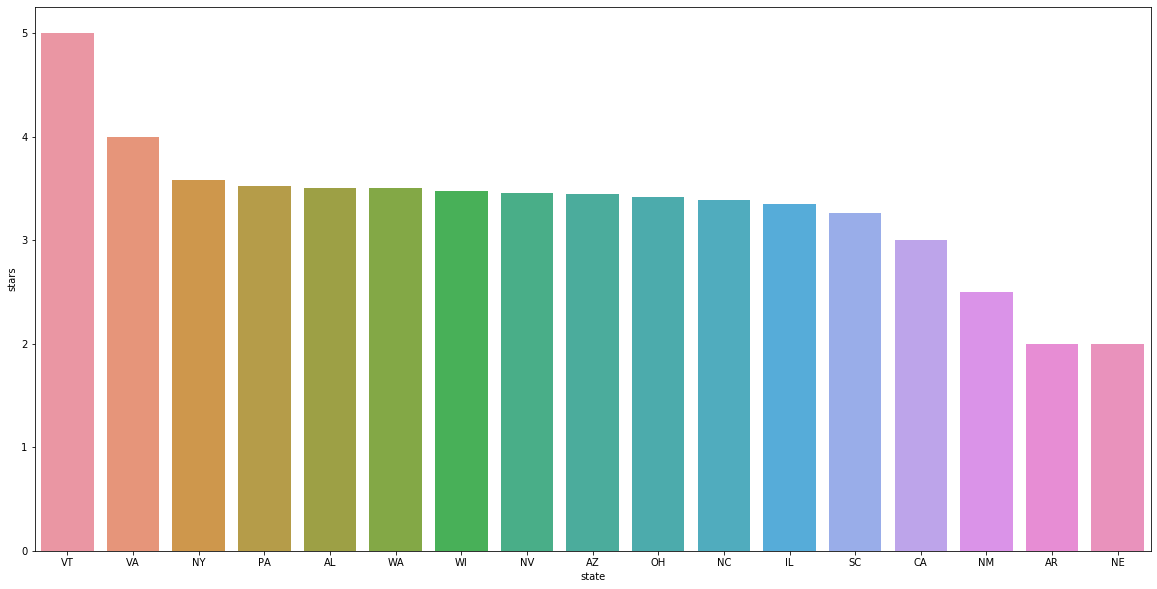

In [18]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
a = sns.barplot(x=avg_stars.index, y="stars", data=avg_stars)

### Now we shall see the distribution of state in this dataset

In [19]:
state_count = business.state.value_counts()

In [20]:
state_count = state_count.to_frame().reset_index()
state_count.columns = ['State', 'Counts']

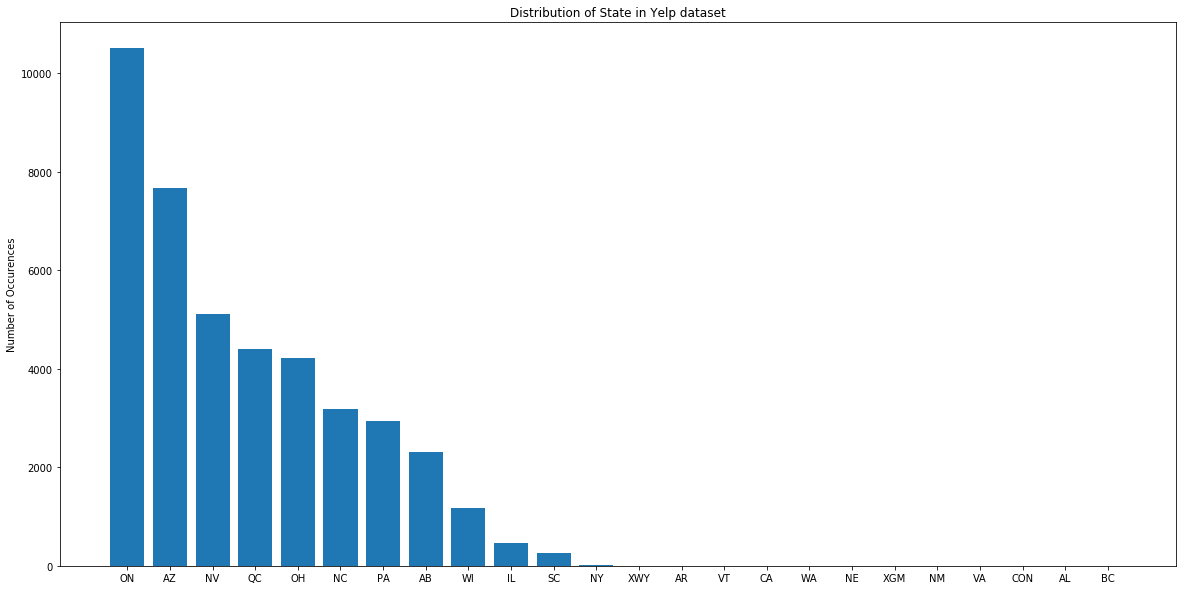

In [21]:
objects = list(state_count.State)
y_pos = np.arange(len(objects))
Numbers = list(state_count.Counts)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.bar(y_pos, Numbers, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Occurences')
plt.title('Distribution of State in Yelp dataset')
plt.show()



### From this, graph, we see the statewise distribution of restaurants. As we can see, this data consists of restaurants present all over the world. For the sake of simplicity, we will focus on the restaurants present in Illinois.

In [22]:
business_in_IL = business[business.state == 'IL']

In [23]:
business_in_IL = business_in_IL.reset_index(drop = True)

In [24]:
business_in_IL

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,mofOjB6flg-eAWOFbOkHfQ,ChinaTown Buffet,713 W Marketview Dr,Champaign,IL,61822,40.137270,-88.256043,2.5,72,1,"{'WiFi': 'u'no'', 'RestaurantsReservations': '...",Restaurants,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
1,m4DwPVxmFDQE_FnGIOa3cQ,Sunny China Buffet,1703 Philo Rd,Urbana,IL,61802,40.097639,-88.191217,3.5,15,1,"{'RestaurantsGoodForGroups': 'True', 'Business...",Restaurants,None
2,HbK6IfznbVToEaKVC0WcSg,The Clark Bar,207 W Clark St,Champaign,IL,61820,40.115017,-88.246156,3.5,24,1,"{'Alcohol': 'u'full_bar'', 'GoodForKids': 'Fal...",Restaurants,"{'Tuesday': '16:0-2:0', 'Wednesday': '16:0-2:0..."
3,o9nGD3J0btXjE9M6IdgZTA,McAlister's Deli,421 Town Center Rd,Champaign,IL,61820,40.141668,-88.250360,3.0,50,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...",Restaurants,"{'Monday': '0:0-0:0', 'Tuesday': '10:30-21:0',..."
4,sDfN5qJlmvrwTfwEPBsxSg,Dairy Queen,1103 Klein Ave,Rantoul,IL,61866,40.311299,-88.142882,2.0,4,1,"{'GoodForKids': 'False', 'BusinessAcceptsCredi...",Restaurants,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,nD4cF5IH8RE7LFGdR2FMUA,Windy City Express,410 N Race St,Urbana,IL,61801,40.116172,-88.208663,3.5,28,1,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'n...",Restaurants,None
453,zTGxLMOd9crAz0XNzqrcrA,Empire Chinese Restaurant,"410 E Green St, Ste 1",Champaign,IL,61820,40.110638,-88.232483,3.5,48,1,"{'BusinessAcceptsCreditCards': 'True', 'BYOBCo...",Restaurants,"{'Monday': '11:0-22:30', 'Tuesday': '11:0-22:3..."
454,0QgFIP9W0eGZSxCSQRQSCg,Subway,"701 S Gregory St, Ste A",Urbana,IL,61801,40.106711,-88.221752,2.5,6,1,"{'RestaurantsDelivery': 'False', 'RestaurantsR...",Restaurants,None
455,gZtJyb2oEpwo1rnovDVPfA,Intermezzo CafÃ©,500 S Goodwin Ave,Urbana,IL,61801,40.108000,-88.222501,3.5,11,1,"{'RestaurantsTakeOut': 'True', 'BusinessAccept...",Restaurants,"{'Monday': '7:30-15:30', 'Tuesday': '7:30-15:3..."


In [25]:
business_in_IL.to_csv("Business_in_Illinois.csv")

In [27]:

# city_il = business_in_IL.city.value_counts()
# city_il = city_il.to_frame().reset_index()
# city['latitude'] = business_in_IL[]
# city_il.columns = ['City', 'Counts']

fig = px.scatter_mapbox(business_in_IL, lat="latitude", lon="longitude", hover_name="city", color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [28]:
city_il = business_in_IL.city.value_counts()
city_il = city_il.to_frame().reset_index()
city_il.columns = ['City', 'Counts']
# labels = list(city_il.City)
# sizes = list(city_il.Counts)
# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(111)
# plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
# plt.axis('equal')
# plt.show()

In [29]:
### Focusing on the stars achieved by the businesses


In [30]:
# #Get the distribution of the ratings
# x=business['stars'].value_counts()
# x=x.sort_index()
# #plot
# plt.figure(figsize=(8,4))
# ax= sns.barplot(x.index, x.values, alpha=0.8)
# plt.title("Star Rating Distribution")
# plt.ylabel('# of businesses', fontsize=12)
# plt.xlabel('Star Ratings ', fontsize=12)

# #adding the text labels
# rects = ax.patches
# labels = x.values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

# plt.show()

###  Distribuiton of restaurant business in Illinois

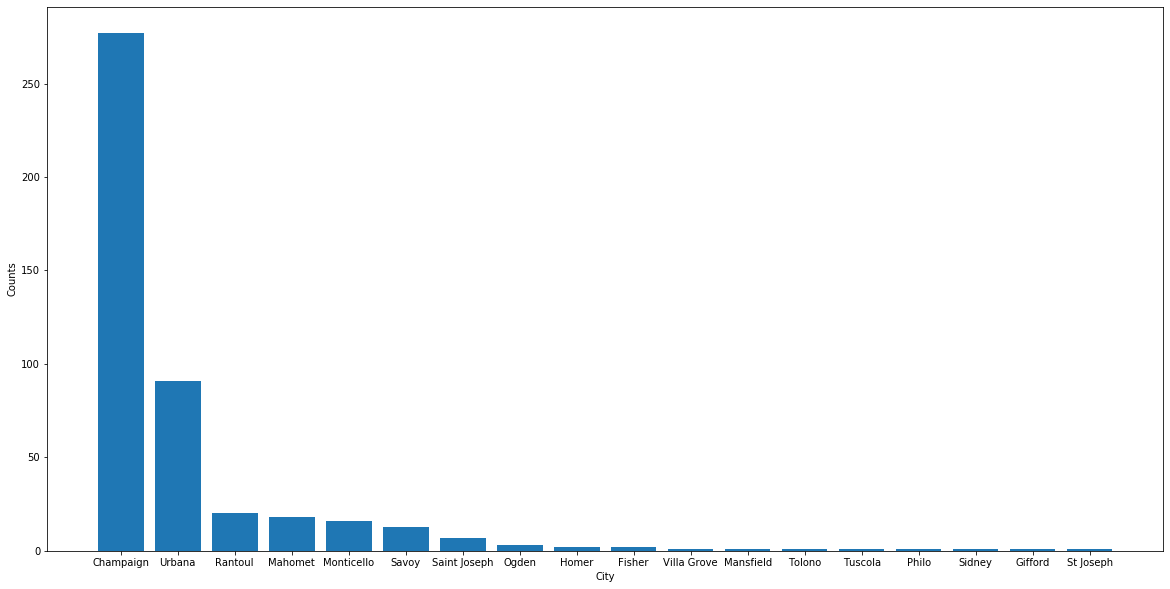

In [31]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.bar(city_il.City, city_il.Counts, align = 'center', alpha = 1)
plt.xlabel("City")
plt.ylabel("Counts")
plt.show()

In [32]:
business_in_IL.attributes[0]

{'WiFi': "u'no'",
 'RestaurantsReservations': 'False',
 'NoiseLevel': "u'average'",
 'GoodForKids': 'True',
 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
 'Caters': 'False',
 'Ambience': "{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}",
 'GoodForMeal': "{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': True, 'brunch': False, 'breakfast': False}",
 'BusinessAcceptsCreditCards': 'True',
 'OutdoorSeating': 'False',
 'RestaurantsTakeOut': 'True',
 'RestaurantsDelivery': 'False',
 'Alcohol': "u'full_bar'",
 'RestaurantsPriceRange2': '2',
 'RestaurantsGoodForGroups': 'True',
 'BikeParking': 'False',
 'RestaurantsAttire': "'casual'",
 'HasTV': 'False'}

### Now we will check which all Restaurants got 5-star ratings and how much

In [33]:
reviews = []
with open(os.path.join(os.getcwd(), 'review.json'),encoding="utf8") as f:
    for line in f:
        reviews.append(json.loads(line))

In [34]:
reviews = pd.DataFrame(reviews)

In [35]:
business_ratings = pd.merge(business_in_IL, reviews[['review_id', 'business_id', 'stars']], on = 'business_id', how = 'left')

In [36]:
Five_star = business_ratings[business_ratings['stars_y'] == 5.0]

In [37]:
Five_star_order = Five_star.name.value_counts()

In [38]:
Five_star_order = Five_star_order.to_frame().reset_index()
Five_star_order.columns = ['Restaurant', 'Counts']


In [39]:
Five_star_order = Five_star_order.head(10)
Five_star_order = Five_star_order.sort_values(['Counts'], ascending = True)
Five_star_order

,Restaurant,Counts
9,Huaraches Moroleon,121
8,Courier Cafe,126
7,Seven Saints,127
6,Farren's Pub & Eatery,128
5,Papa Del's Pizza,141
4,Sakanaya,232
3,DESTIHL Restaurant & Brew Works,243
2,Golden Harbor Authentic Chinese Cuisine,246
1,Maize Mexican Grill,350
0,Black Dog Smoke & Ale House,668


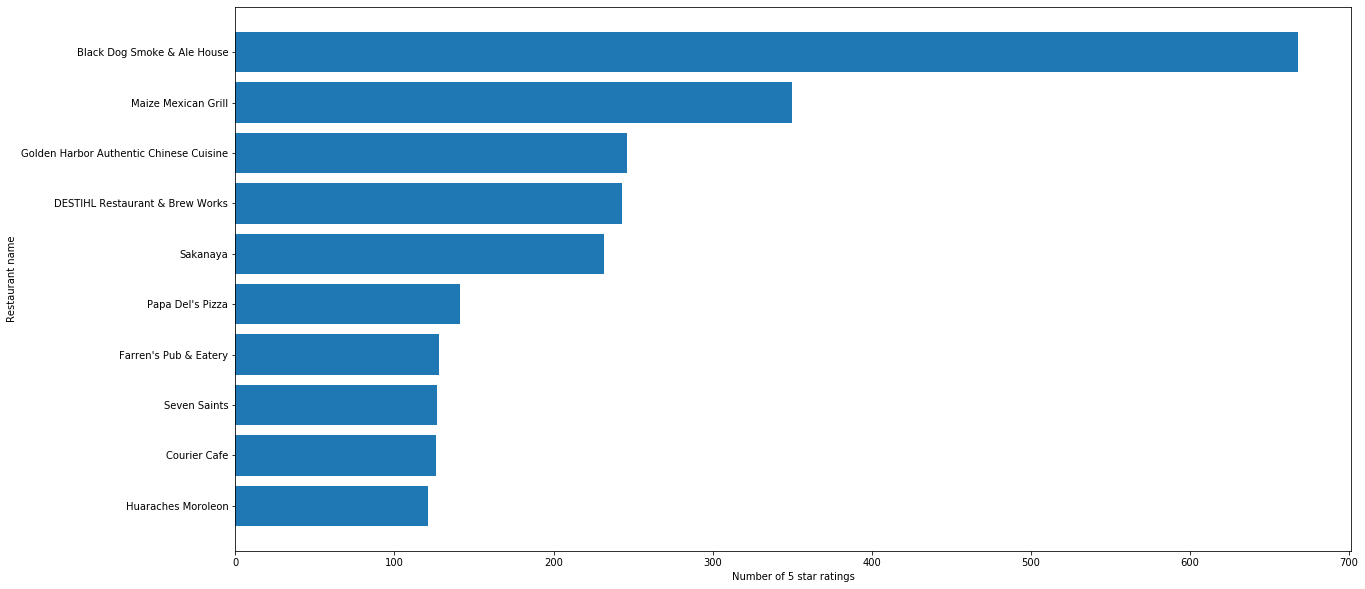

In [40]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)
plt.barh(Five_star_order.Restaurant, Five_star_order.Counts, align = 'center', alpha = 1)
plt.ylabel('Restaurant name')
plt.xlabel('Number of 5 star ratings')
plt.show()

### We can deduce  Black Dog Smoke & Ale House got the highest amount of 5-star ratings.

In [39]:
reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [40]:
reviews[reviews.business_id == '9MnbQg7kfb_WgxoV0hXKSQ']

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
3333982,x20Vhj5qcBbW-08vEbFHOw,lg1UvP-7KLtjSdxbFbt3Aw,9MnbQg7kfb_WgxoV0hXKSQ,5.0,0,0,1,"This place is without a doubt, the BEST BBQ IN...",2011-10-27 15:48:15
3334583,BUxau3CCZwnfPZrBt3vK0Q,Jd__AkH8jPv9wN6bfmTW1A,9MnbQg7kfb_WgxoV0hXKSQ,5.0,1,0,0,Excellence BBQ. Applesauce and green beans as...,2018-02-24 02:32:05
3335733,2h1BHzhitC9ktYXcTfNqfA,dYAhuu1xauHTh-uhwnMcQw,9MnbQg7kfb_WgxoV0hXKSQ,4.0,0,0,0,Beer flights and food were amazing here!! We ...,2011-04-22 02:16:21
3335926,KGHDKrH6ptbvhTJ7NTdQSQ,eEbdbw_Tt6FvqB0Lv_03GA,9MnbQg7kfb_WgxoV0hXKSQ,5.0,0,0,0,Burrito special on Thursday. Best burrito I'v...,2016-02-11 22:14:01
3336487,lPCfdNu1OmI3QsZMIiBjyQ,Tu3EqdHkeEJeRzOvdvGORw,9MnbQg7kfb_WgxoV0hXKSQ,5.0,0,0,0,Two words to describe this joint: outstanding ...,2012-04-28 21:31:09
...,...,...,...,...,...,...,...,...,...
3986958,Kk_xZZ0I85DHj9v4uOQlmQ,AKmLoFB0QL-OamsWlNWcOw,9MnbQg7kfb_WgxoV0hXKSQ,5.0,0,0,0,Why oh why couldn't this place stay a bigger s...,2010-04-24 23:03:26
3987494,JfDKfXhJNiwuOcRasybWrw,Pyg6kCS9FYIwVORtrlA-CQ,9MnbQg7kfb_WgxoV0hXKSQ,5.0,0,0,0,This place is easily my FAVORITE bbq joint in ...,2010-06-25 23:23:36
3988239,wvOgWOwmqaisFL8YgTy4oA,qw_BuLGXnDilUAvZD6v9zw,9MnbQg7kfb_WgxoV0hXKSQ,5.0,1,0,0,"Black Dog is, hands down, my favorite restaura...",2010-08-11 21:17:00
3988939,XN6wOK9A7nGCZBUpyDgAaw,CVAU1YkPleuUzxzW4P-YOw,9MnbQg7kfb_WgxoV0hXKSQ,5.0,0,0,0,Even though myself and my girlfriend showed up...,2010-04-27 05:01:42


In [41]:
business_in_IL[business_in_IL.name == 'Black Dog Smoke & Ale House'].reset_index(drop = True).iloc[0]

business_id                                9MnbQg7kfb_WgxoV0hXKSQ
name                                  Black Dog Smoke & Ale House
address                                        201 N Broadway Ave
city                                                       Urbana
state                                                          IL
postal_code                                                 61801
latitude                                                  40.1138
longitude                                                -88.2077
stars                                                         4.5
review_count                                                  790
is_open                                                         1
attributes      {'RestaurantsDelivery': 'False', 'RestaurantsA...
categories                                            Restaurants
hours           {'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...
Name: 0, dtype: object